## Basic deterministic under-sampling

We want to generate a sampling mask $\Omega \in \{0, 1\}^N$ such that $y = F_\Omega x$ where $x \in R^N$ in the original image. The data $y$ is then corrupted by additive noise $b$:

$$
y = F_\Omega x + b
$$

where $b$ is a complex-valued circular Gaussian noise of variance $\sigma^2$ and $F_\Omega=\Omega F$ in this **Cartesian** setting (i.e. sampling on the grid).

We consider:

1. a low-frequency Cartesian mask $\Omega$ is defined by *the central lines* of k-space
2. a low-frequency Cartesian mask $\Omega$ is defined by *a square box* in k-space centered at $(k_x, k_y) = (0,0)$
3. a high-frequency Cartesian mask $\Omega$ is defined as the complementary set of the lines defined in to 1)
4. a high-frequency Cartesian mask $\Omega$ is defined as the complementary set of the box defined in 2)

Based on these masks we generate the correspond measured data from a reference MR image and finally perform Cartesian image reconstruction $\hat x$ from the under-sampled data $y$ as follows:

$$
\hat x = F^* y
$$

where $F^*$ is the zero-filled inverse Fourier transform (ifft).

We first read an "original image" of MRI with a 2D dimension of $512 \times 512$, and then add some noise to it to simulate the real scenario.

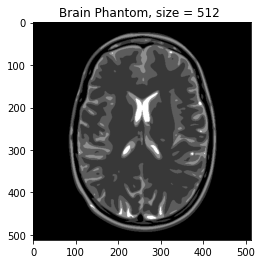

In [3]:
## Display Brain Phantom
%matplotlib inline
import os
import os.path as op
import math

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io

dirimg_2d = "./data/"
img_size = 512 # also 256
FOV = 0.2 # Field of view in m
pixelSize = FOV/ img_size

# load data file corresponding to the target resolution
filename = "BrainPhantom%s.png" % img_size
mri_filename = dirimg_2d + filename
mri_img = io.imread(mri_filename)

# plotting
plt.figure()
plt.title("Brain Phantom, size = %s " % img_size)
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

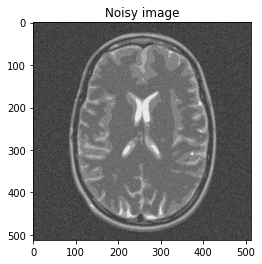

In [4]:
# add noise to image
noise_img = np.copy(mri_img.astype('float64'))
noise_img += np.random.randn(*mri_img.shape) * 20.

plt.figure()
plt.imshow(noise_img, cmap='Greys_r')
plt.title("Noisy image")
plt.savefig("data/noisy_brain.png")
plt.show()

After that, the object is to construct a low-frequency sampling mask that consists of the central k-space lines. We implement Fourier transform the reference MR image to compute k-space data, add zero-mean Gaussian complex-valued noise. And then, we mask the data using the above defined mask. Next, we perform a zero-filled MR image reonstruction from masked k-space data.

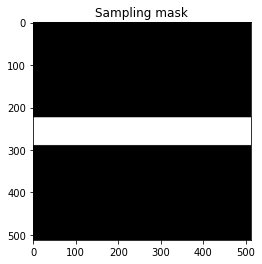

In [5]:
# Generate trivial Cartesian sampling masks
## img_size = 512

mask = "low_res"
factor_ctr = 8

# Construct a k-space mask that consists of the central lines
## 0 entries: points not sampled; 1 entries: points to be sampled
## Initialize k-space with 0 everywhere and then place the "1" appropriately.

kspace_masklines = np.zeros((img_size, img_size), dtype="float64") # a zero-filled mask
low_res_size = img_size // factor_ctr + 1 # calculate the sampling area width, a total of 65 entries 
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size) # get all entries in this interval
idx_vec_ = idx_vec.astype("int") # Get the serial number of each entry
kspace_masklines[idx_vec_, ] = 1 # Turn these entries to 1

# Show the mask
plt.figure()
plt.imshow(kspace_masklines, cmap="Greys_r")
plt.title("Sampling mask")
plt.show()

In [6]:
# Define Fourier and Inverse Fourier Transform

norm = "ortho"

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

The overall pipeline of what we do next is as followed:
![](imgs/x-k-flow.png)

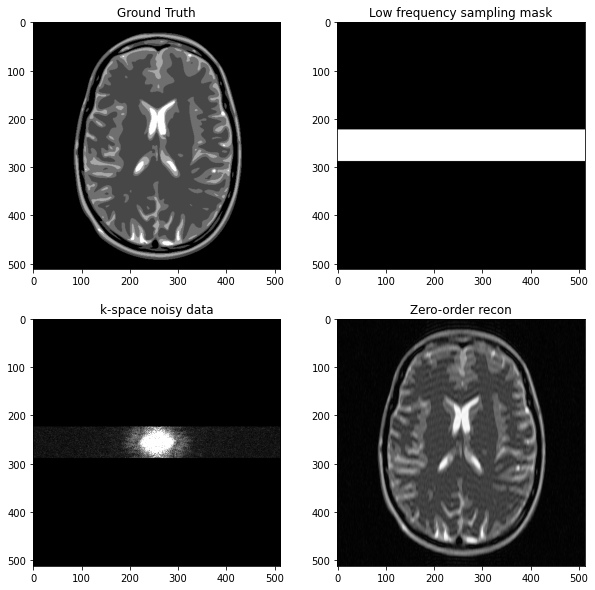

In [7]:
# Generate the kspace data
## First we Fourier transform the image 
kspace_data = np.fft.fftshift(fft(mri_img))
## add Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)

## Mask data to perform subsampling
kspace_data *= kspace_masklines

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

# imshow
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap="Greys_r")
axs[0, 0].set_title("Ground Truth")
axs[0, 1].imshow(kspace_masklines, cmap="Greys_r")
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data), cmap='Greys_r', vmax=0.01 * np.abs(kspace_data).max()) # scale up the noise
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap="Greys_r")
axs[1, 1].set_title("Zero-order recon")

plt.show()

Based on the previous example, try to construct a low-frequency sampling mask defined by **a square box** centered around $(k_x, k_y)=(0, 0)$

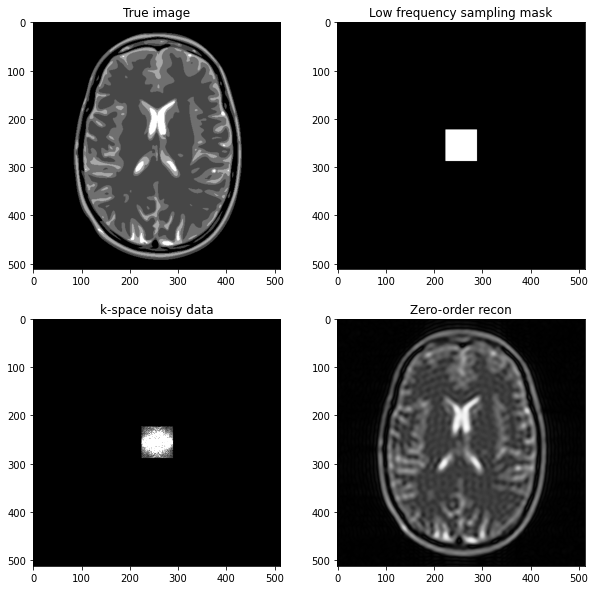

In [19]:
# Construct a k-space mask consisting of a central box
## Initalize k-space with 0
kspace_maskbox = np.zeros((img_size, img_size), dtype="float64")
# fill the rectangle with 1
kspace_maskbox[idx_vec_, ] = 1

## Get the whole list [0, ..., 511]
list_img_size = np.arange(0., img_size).tolist()
## filter the [223, ..., 287]
filtered_center = [x for x in list_img_size if x not in idx_vec_]
## set the filtered array to 0, the other is 1 
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")
kspace_maskbox[:, array_idx_center_] = 0

# fft -> fftshift -> add noise and apply mask -> ifftshift -> ifft
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_maskbox

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_maskbox, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

Next is to construct a k-space sampling mask that consists of the high-frquency lines, without the central lines. Let's see how it would be.

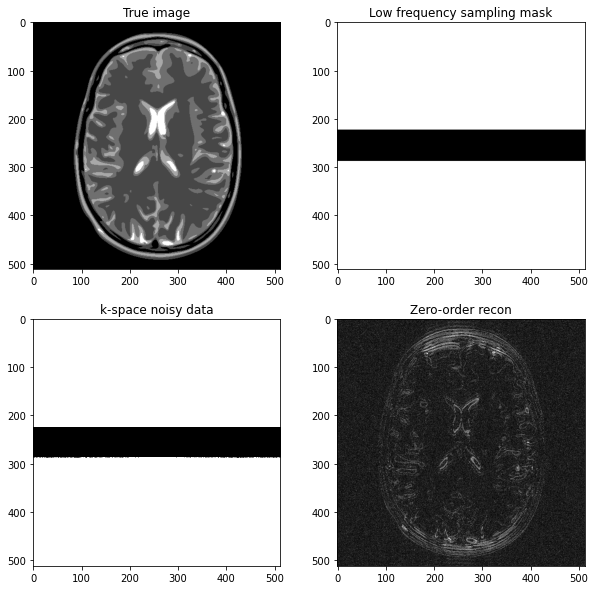

In [21]:
# Generate trivial Cartesian sampling masks
## img_size = 512

mask = "low_res"
factor_ctr = 8

# Construct a k-space mask that consists of the central lines
## 0 entries: points not sampled; 1 entries: points to be sampled
## Initialize k-space with 0 everywhere and then place the "1" appropriately.

kspace_masklines = np.ones((img_size, img_size), dtype="float64") # a zero-filled mask
low_res_size = img_size // factor_ctr + 1 # calculate the sampling area width, a total of 65 entries 
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size) # get all entries in this interval
idx_vec_ = idx_vec.astype("int") # Get the serial number of each entry
kspace_masklines[idx_vec_, ] = 0 # Turn these entries to 1

# fft -> fftshift -> add noise and apply mask -> ifftshift -> ifft
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_masklines

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_masklines, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()


Based on the previous examples, try to construct a k-space mask that consists of the removing the central box centered in $(k_x, k_y)=(0, 0)$.

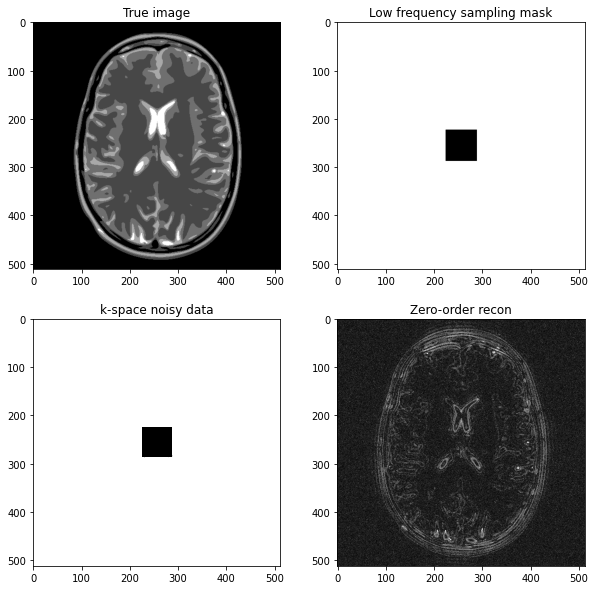

In [22]:
# Construct a k-space mask consisting of a central box
## Initalize k-space with 0
kspace_maskbox = np.ones((img_size, img_size), dtype="float64")
# fill the rectangle with 1
kspace_maskbox[idx_vec_, ] = 0

## Get the whole list [0, ..., 511]
list_img_size = np.arange(0., img_size).tolist()
## filter the [223, ..., 287]
filtered_center = [x for x in list_img_size if x not in idx_vec_]
## set the filtered array to 0, the other is 1 
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")
kspace_maskbox[:, array_idx_center_] = 1

# fft -> fftshift -> add noise and apply mask -> ifftshift -> ifft
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_maskbox

## zero order solution
img_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_maskbox, cmap='Greys_r')
axs[0, 1].set_title("Low frequency sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(img_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()

Now we can compare the differences among all these reconstructed images. Let's summarise the code here:

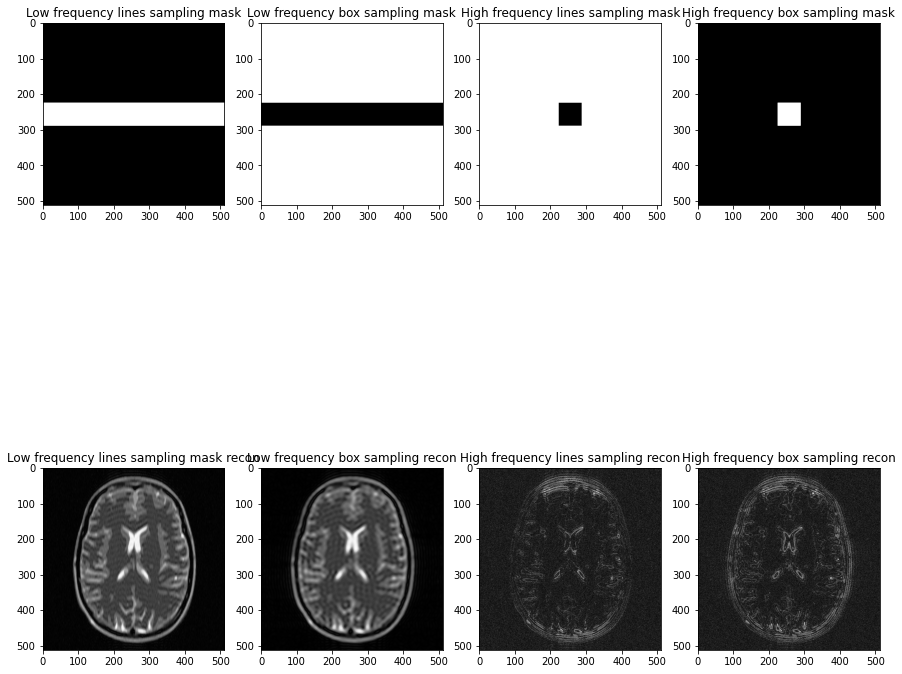

In [43]:
# We have the original image `x`
img_size = 512 # also 256
FOV = 0.2 # Field of view in m
pixelSize = FOV/ img_size
filename = "BrainPhantom%s.png" % img_size
mri_filename = './data/' + filename
mri_img = io.imread(mri_filename)

# Then we construct the mask
factor_ctr = 8
mask_low_lines = np.zeros((img_size, img_size), dtype="float64")
low_res_size = img_size // factor_ctr + 1
idx_vec = np.linspace(img_size // 2 - low_res_size // 2, img_size // 2 + low_res_size // 2, low_res_size)
idx_vec_ = idx_vec.astype("int")

## low_freq_lines
mask_low_lines[idx_vec_, ] = 1
## high-freq-lines
mask_high_lines = 1 - mask_low_lines
mask_high_lines_bak = np.copy(mask_high_lines)

list_img_size = np.arange(0., img_size).tolist()
filtered_ceter = [x for x in list_img_size if x not in idx_vec_]
array_idx_center = np.array(filtered_center)
array_idx_center_ = array_idx_center.astype("int")

## high_freq_box
mask_high_lines[:, array_idx_center_]=1
mask_high_box = mask_high_lines
mask_high_lines = mask_high_lines_bak
## low_freq_box
mask_low_box = 1 - mask_high_box

# Implement Fourier Transform
kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)

# Get the reconstructed result
recon_low_freq_lines = ifft(np.fft.ifftshift(kspace_data * mask_low_lines))
recon_low_freq_box = ifft(np.fft.ifftshift(kspace_data * mask_low_box))
recon_high_freq_lines = ifft(np.fft.ifftshift(kspace_data * mask_high_lines))
recon_high_freq_box = ifft(np.fft.ifftshift(kspace_data * mask_high_box))

# Plotting
fig, axs = plt.subplots(2, 4, figsize=(15, 15))
## 4 masks
axs[0, 0].imshow(mask_low_lines, cmap='Greys_r')
axs[0, 0].set_title("Low frequency lines sampling mask")
axs[0, 1].imshow(mask_high_lines, cmap='Greys_r')
axs[0, 1].set_title("Low frequency box sampling mask")
axs[0, 2].imshow(mask_high_box, cmap='Greys_r')
axs[0, 2].set_title("High frequency lines sampling mask")
axs[0, 3].imshow(mask_low_box, cmap='Greys_r')
axs[0, 3].set_title("High frequency box sampling mask")

axs[1, 0].imshow(np.abs(recon_low_freq_lines), cmap='Greys_r')
axs[1, 0].set_title("Low frequency lines sampling mask recon")
axs[1, 1].imshow(np.abs(recon_low_freq_box), cmap='Greys_r')
axs[1, 1].set_title("Low frequency box sampling recon")
axs[1, 2].imshow(np.abs(recon_high_freq_lines), cmap='Greys_r')
axs[1, 2].set_title("High frequency lines sampling recon")
axs[1, 3].imshow(np.abs(recon_high_freq_box), cmap='Greys_r')
axs[1, 3].set_title("High frequency box sampling recon")
plt.show()


We can see that, the low frequency part occupies the dominant part of the information in k-space, especially in the center box area. And the more you sampled, the more you can reconstructed (in zero-filled method).